# Fraudulent Activities - PART I

### OBJECTIF

Les sites de E-commerce font transiter beaucoup d'argent. Cela peut engendrer des risques non négligeables d'activités frauduleuses, comme l'utilisation de carte de crédit volées, du blanchiment d'argent, etc.

Fort heureusement, le Machine Learning peut nous aider à identifier ces activités frauduleuses. Tous les sites web où vous devez entrer vos informations de paiements ont une équipe qui s'occupe de gérer les risques de fraude via le ML.

Le but de ce challenge est de construire un modèle qui vous permet de prédire une probabilité de transaction frauduleuse.

### DESCRIPTION

L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

2. Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

3. Votre patron aimerait comprendre votre modèle car il est inquiet d'utiliser un modèle _black box_. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématique. Par exemple, quels sont les utilisateurs qui peuvent être classés comme _risqués_ ?

4. Supposons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vue Produit, comment l'utiliseriez-vous ? Comment pourriez-vous penser l'expérience utilisateur face à ce produit ?


### DATA

Vous pouvez utiliser les deux tables suivantes :

```python
Fraud_Data
```

&

```python
IpAddress_to_Country
```


In [1]:
!pip install s3fs

## Import Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Predict the likelihood of a fraudulent transaction

In [3]:
# Lecture des fichiers
df1 = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/Fraud_Data.csv")

In [4]:
df1.head(6)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [5]:
ip_country = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/IpAddress_to_Country.csv")

In [6]:
ip_country.head(6)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan


In [7]:
df1.shape

(151112, 11)

In [8]:
ip_country.shape

(138846, 3)

In [9]:
df1['ip_address']

0         7.327584e+08
1         3.503114e+08
2         2.621474e+09
3         3.840542e+09
4         4.155831e+08
              ...     
151107    3.451155e+09
151108    2.439047e+09
151109    2.748471e+09
151110    3.601175e+09
151111    4.103825e+09
Name: ip_address, Length: 151112, dtype: float64

In [10]:
df1.describe(include='all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-04-28 12:29:12,2015-07-17 23:22:55,NaN,ZUSVMDEZRBDTX,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


In [11]:
ip_country.isnull().count()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                   138846
dtype: int64

## Country of origin from IP address

In [12]:
# Revoir la Methode
def transform_ip(arg):
    try:
        return ip_country.country[(ip_country.lower_bound_ip_address < arg) & (ip_country.upper_bound_ip_address > arg)].iloc[0]
    except IndexError:
        return "Unknown country"  
      
df1["country_name"] = df1.ip_address.apply(transform_ip)

In [13]:
df1.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,Unknown country
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


## Management - Transformation - Restructuring of Dates / Times

In [14]:
df1.signup_time = pd.to_datetime(df1.signup_time, format="%Y-%m-%d %H:%M:%S")
df1.purchase_time = pd.to_datetime(df1.purchase_time, format="%Y-%m-%d %H:%M:%S")
df1["time_delta"] = (df1.purchase_time - df1.signup_time) / np.timedelta64(1, 's')

In [15]:
df1['year'] = pd.DatetimeIndex(df1['purchase_time']).year
df1['month'] = pd.DatetimeIndex(df1['purchase_time']).month
df1.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,time_delta,year,month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,2015,4
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,2015,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,2015,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085.0,2015,5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,2015,9
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,2015,7
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,Unknown country,2177825.0,2015,8
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States,4268729.0,2015,5
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China,3594200.0,2015,6
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States,4943753.0,2015,3


In [16]:
df1=df1.drop(columns=['user_id'])
df1.head(6)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,time_delta,year,month
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,2015,4
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,2015,6
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,2015,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085.0,2015,5
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,2015,9
5,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,2015,7


In [17]:
df1.describe(include='all')

<ipython-input-17-f89e5509e305>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.describe(include='all')
<ipython-input-17-f89e5509e305>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.describe(include='all')


,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,time_delta,year,month
count,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000,151112,1.511120e+05,151112.0,151112.000000
unique,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN,182,NaN,NaN,NaN
top,2015-06-30 03:58:38,2015-07-17 23:22:55,NaN,ZUSVMDEZRBDTX,SEO,Chrome,M,NaN,NaN,NaN,United States,NaN,NaN,NaN
freq,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN,58049,NaN,NaN,NaN
first,2015-01-01 00:00:42,2015-01-01 00:00:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-08-18 04:40:29,2015-12-16 02:56:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646,NaN,4.932029e+06,2015.0,6.008629
std,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336,NaN,3.126263e+06,0.0,2.660637
min,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN,1.000000e+00,2015.0,1.000000
25%,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000,NaN,2.186754e+06,2015.0,4.000000


In [18]:
df1.shape

(151112, 14)

In [19]:
df1.isnull().count()

signup_time       151112
purchase_time     151112
purchase_value    151112
device_id         151112
source            151112
browser           151112
sex               151112
age               151112
ip_address        151112
class             151112
country_name      151112
time_delta        151112
year              151112
month             151112
dtype: int64

In [20]:
df1 = df1.rename(columns={"class": "f_not_f"})
df1.head(5)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,f_not_f,country_name,time_delta,year,month
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,2015,4
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,2015,6
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,2015,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085.0,2015,5
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,2015,9


## Exploratory visualization

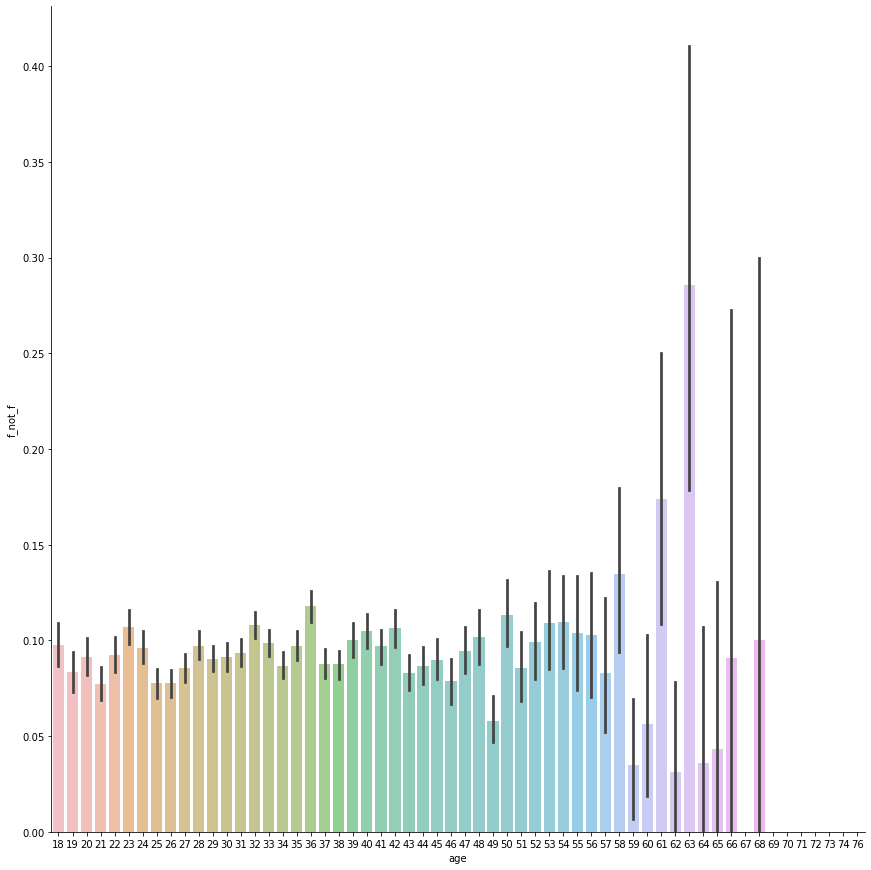

In [21]:
viz_1=sns.catplot(x="age", y="f_not_f", data = df1, kind="bar",alpha=.6, height=12)


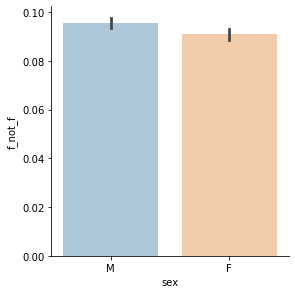

In [22]:
viz_1=sns.catplot(x="sex", y="f_not_f", data = df1, kind="bar",alpha=.4, height=4)

## Choice of dataset variables

In [23]:
# Drop columns with too many unique values
df1 = df1.drop(['signup_time', 'purchase_time', 'device_id','ip_address','year'], axis=1)
df1.head(5)

,purchase_value,source,browser,sex,age,f_not_f,country_name,time_delta,month
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,4
1,16,Ads,Chrome,F,53,0,United States,17944.0,6
2,15,SEO,Opera,M,53,1,United States,1.0,1
3,44,SEO,Safari,M,41,0,Unknown country,492085.0,5
4,39,Ads,Safari,M,45,0,United States,4361461.0,9


In [24]:
c_counts=df1['country_name'].value_counts()
c_counts

United States      58049
Unknown country    21966
China              12038
Japan               7306
United Kingdom      4490
                   ...  
San Marino             1
Tajikistan             1
Madagascar             1
Dominica               1
Turkmenistan           1
Name: country_name, Length: 182, dtype: int64

In [25]:
c_counts = df1['country_name'].value_counts()

In [26]:
# Select countries according to the number of values present
to_keep_country=c_counts[c_counts > 50].index.values
to_keep_country

array(['United States', 'Unknown country', 'China', 'Japan',
       'United Kingdom', 'Korea Republic of', 'Germany', 'France',
       'Canada', 'Brazil', 'Italy', 'Australia', 'Netherlands',
       'Russian Federation', 'India', 'Taiwan; Republic of China (ROC)',
       'Mexico', 'Sweden', 'Spain', 'South Africa', 'Switzerland',
       'Poland', 'Argentina', 'Indonesia', 'Norway', 'Colombia', 'Turkey',
       'Viet Nam', 'Romania', 'Denmark', 'Hong Kong', 'Finland',
       'Austria', 'Ukraine', 'Chile', 'Belgium',
       'Iran (ISLAMIC Republic Of)', 'Egypt', 'Czech Republic',
       'Thailand', 'New Zealand', 'Israel', 'Saudi Arabia', 'Venezuela',
       'Ireland', 'European Union', 'Greece', 'Portugal', 'Hungary',
       'Malaysia', 'Singapore', 'Pakistan', 'Philippines', 'Bulgaria',
       'Morocco', 'Algeria', 'Peru', 'Tunisia', 'United Arab Emirates',
       'Ecuador', 'Lithuania', 'Seychelles', 'Kenya', 'Kazakhstan',
       'Costa Rica', 'Kuwait', 'Slovenia', 'Slovakia (SLOVAK R

In [27]:
df1 = df1.loc[df1['country_name'].isin(to_keep_country), :]

In [29]:
target_name = 'f_not_f'
print("Separating labels from features...")
Y = df1.loc[:,target_name]
X = df1.loc[:,[c for c in df1.columns if c!=target_name]] 
print("...Done.")
print(Y.head())
print(X.head())


Separating labels from features...
...Done.
0    0
1    0
2    1
3    0
4    0
Name: f_not_f, dtype: int64
   purchase_value source browser sex  age     country_name  time_delta  month
0              34    SEO  Chrome   M   39            Japan   4506682.0      4
1              16    Ads  Chrome   F   53    United States     17944.0      6
2              15    SEO   Opera   M   53    United States         1.0      1
3              44    SEO  Safari   M   41  Unknown country    492085.0      5
4              39    Ads  Safari   M   45    United States   4361461.0      9


## Estimated class balance

In [30]:
not_fraud = df1['f_not_f'].value_counts()
not_fraud

0    135854
1     14079
Name: f_not_f, dtype: int64

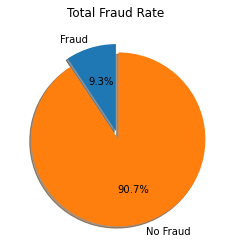

In [31]:
labels = 'Fraud', 'No Fraud'
sizes = [9.3, 90.6]
explode = (0, 0.1) # Here, only the Hogs will be highlighted.

plt.pie(sizes, explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Total Fraud Rate")
plt.show()

## Preprocessing

In [32]:
X = X.values
Y = Y.tolist()

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [34]:
df1.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'f_not_f',
       'country_name', 'time_delta', 'month'],
      dtype='object')

In [35]:
print(X[0:5,:])
print(Y[0:5])

[[34 'SEO' 'Chrome' 'M' 39 'Japan' 4506682.0 4]
 [16 'Ads' 'Chrome' 'F' 53 'United States' 17944.0 6]
 [15 'SEO' 'Opera' 'M' 53 'United States' 1.0 1]
 [44 'SEO' 'Safari' 'M' 41 'Unknown country' 492085.0 5]
 [39 'Ads' 'Safari' 'M' 45 'United States' 4361461.0 9]]
[0, 0, 1, 0, 0]


In [36]:
categorical_features = [1, 2, 3, 5]
numeric_features = [0, 4, 6, 7]

In [37]:
standard_scaler = StandardScaler()  # pour mettre à l'echelle les variables numériques (à partir de la moyenne et de l'écart-ty du train)
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)  # pour générer les dummies des colonnes catégorielles de X (à partir des catégories présentes dans le train)

# ColumnTransformer va permettre d'appliquer l'ensemble des outils précédents aux colonnes adaptées
preprocessor = ColumnTransformer(
    transformers=[   
        ('scaling', standard_scaler, numeric_features),
        ('dummies', one_hot_encoder, categorical_features)
        ]
    )

# la méthode fit_transform est un raccourcie pour les méthodes fit et transform
X_train = preprocessor.fit_transform(X_train)

# /!\ on applique uniquement la méthode transform aux données de test (jamais la méthode fit)
X_test = preprocessor.transform(X_test)

In [38]:
X = df1.select_dtypes('number')
X

,purchase_value,age,f_not_f,time_delta,month
0,34,39,0,4506682.0,4
1,16,53,0,17944.0,6
2,15,53,1,1.0,1
3,44,41,0,492085.0,5
4,39,45,0,4361461.0,9
...,...,...,...,...,...
151107,43,28,1,5261233.0,3
151108,35,32,0,931270.0,5
151109,40,26,0,6681616.0,5
151110,46,37,0,5146119.0,9


### Logistic Regression

In [39]:
# Train baseline model
model = LogisticRegression(class_weight = 'balanced', max_iter = 800) 
print("Training model...")
model.fit(X_train, Y_train) 

Training model...


LogisticRegression(class_weight='balanced', max_iter=800)

In [40]:
# Predictions on training set
Y_train_pred = model.predict(X_train)
print(Y_train_pred[0:5])

[1 0 1 1 0]


In [41]:
# Predictions on test set
Y_test_pred = model.predict(X_test)
print(Y_test_pred[0:5])

[0 0 1 0 0]


In [42]:
# Print scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.31089235331672055
f1-score on test set :  0.3049557375692893


<AxesSubplot:>

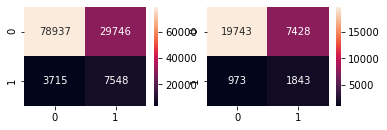

In [43]:
plt.subplot(221)
cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.subplot(222)
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt=".0f")

### Train Random Forest with grid search

In [44]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

params = {
    'n_estimators': [100, 200],
    'max_depth': [2,6]
}
model = GridSearchCV(rf, param_grid = params, verbose=2)
model.fit(X_train, Y_train) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=2, n_estimators=100, total=   4.0s
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] .................... max_depth=2, n_estimators=100, total=   3.9s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   3.9s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   3.9s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   3.7s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .................... max_depth=2, n_estimators=200, total=   7.5s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .................... max_depth=2, n_estimators=200, total=   7.6s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .................... max_depth=2, n_estimators=200, total=   7.5s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.1min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 6], 'n_estimators': [100, 200]},
             verbose=2)

In [45]:
# Predictions on training set
Y_train_pred = model.predict(X_train)
print("...")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...")
print(Y_test_pred[0:5])
print()


...
[0 0 1 0 0]

Predictions on test set...
...
[0 0 0 0 0]



In [46]:
# Print scores
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.6991973205520587
f1-score on test set :  0.7023041474654378


In [47]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

print('--- Train set ---')
print('Precision : ', precision_score(Y_train, Y_train_pred))
print('Recall : ', recall_score(Y_train, Y_train_pred))
print()
print('--- Test set ---')
print('Precision : ', precision_score(Y_test, Y_test_pred))
print('Recall : ', recall_score(Y_test, Y_test_pred))
print()

--- Train set ---
Precision :  1.0
Recall :  0.5375122081150671

--- Test set ---
Precision :  1.0
Recall :  0.5411931818181818



<AxesSubplot:>

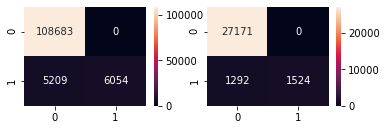

In [48]:
plt.subplot(221)
cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.subplot(222)
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt=".0f")

### SVC

In [49]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', class_weight='balanced')

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
%time svm.fit(X_train, y_train)

CPU times: user 817 ms, sys: 59.8 ms, total: 877 ms
Wall time: 877 ms


SVC(class_weight='balanced')

In [52]:
%time svm.score(X_test, y_test)

CPU times: user 78.9 ms, sys: 1.06 ms, total: 79.9 ms
Wall time: 78.7 ms


1.0

In [53]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.6991973205520587
f1-score on test set :  0.7023041474654378


In [54]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

print('--- Train set ---')
print('Precision : ', precision_score(Y_train, Y_train_pred))
print('Recall : ', recall_score(Y_train, Y_train_pred))
print()
print('--- Test set ---')
print('Precision : ', precision_score(Y_test, Y_test_pred))
print('Recall : ', recall_score(Y_test, Y_test_pred))
print()


--- Train set ---
Precision :  1.0
Recall :  0.5375122081150671

--- Test set ---
Precision :  1.0
Recall :  0.5411931818181818



<AxesSubplot:>

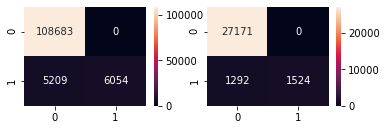

In [55]:
plt.subplot(221)
cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.subplot(222)
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt=".0f")

### Boosting

In [56]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier 

In [57]:
regressor_ada = AdaBoostClassifier()
regressor_ada.fit(X_train, Y_train)
# Score en R2
AdaBoost_score_train = regressor_ada.score(X_train, Y_train)
AdaBoost_score_test = regressor_ada.score(X_test, Y_test)
print("Score Adaboost default train {}".format(regressor_ada.score(X_train, Y_train)))
print("Score Adaboost default test {}".format(regressor_ada.score(X_test, Y_test)))
print()

Score Adaboost default train 1.0
Score Adaboost default test 1.0



In [58]:
regressor_xgb = XGBClassifier(max_depth=3)
regressor_xgb.fit(X_train, Y_train)
Xgb_score_train = regressor_xgb.score(X_train, Y_train)
Xgb_score_test = regressor_xgb.score(X_test, Y_test)
print("Score XGBoost default train {}".format(regressor_xgb.score(X_train, Y_train)))
print("Score XGBoost default test {}".format(regressor_xgb.score(X_test, Y_test)))
print()

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score XGBoost default train 1.0
Score XGBoost default test 1.0



<AxesSubplot:>

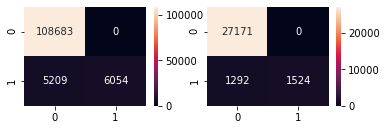

In [59]:
plt.subplot(221)
cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.subplot(222)
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt=".0f")

In [60]:
# En conclusion rapide nous voyons bien l'impact sur la performance avec les methodes ensembliste

In [61]:
# .... A continuer